In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import os, skvideo.io, json
import zarr

In [3]:
# Fix for stupid skvideo/numpy backwards compatability fuck up
np.float = np.float64
np.int = np.int_

In [4]:
def collect_data(data_dir_path):
    '''Loads video data and checks that corresponding position data exists.'''

    data_dir = os.fsencode(data_dir_path)
    img_data = []
    pos_data = []
    for file in os.listdir(data_dir):
        filename = os.fsdecode(file)
        if filename.endswith(".mp4"):
            print(filename)
            try:
                videodata = skvideo.io.vread(f"{data_dir_path}{filename}")
                timestamp = filename[:-4].split('_')[-1]
                try:
                    with open(f"{data_dir_path}positional_data_{timestamp}.json", 'r') as file:
                        pos_data = json.load(file)
                    img_data.append(videodata)
                    pos_data.append(pos_data)
                except FileNotFoundError as e:
                    print(f"BAD POSITION FILE: {e}")
            except ValueError as e:
                print(f"BAD VIDEO: {e}")
        elif filename.endswith(".json"):
            continue

    return img_data, pos_data

In [5]:
def load_data(data_dir_path):
    '''Loads all data without checking that (img,position) pair exists.'''

    data_dir = os.fsencode(data_dir_path)
    img_data = []
    pos_data = []
    for file in os.listdir(data_dir):
        filename = os.fsdecode(file)
        if filename.endswith(".mp4"):
            try:
                videodata = skvideo.io.vread(
                    f"{data_dir_path}{filename}"
                )
                img_data.append(videodata)
            except ValueError as e:
                print(f"BAD VIDEO {filename}: {e}")
        elif filename.endswith(".json"):
            try:
                with open(f"{data_dir_path}{filename}", 'r') as file:
                    position = json.load(file)
                pos_data.append(position)
            except FileNotFoundError as e:
                print(f"Bad position {filename}: {e}")

    return img_data, pos_data

In [6]:
data_dir = "data/pusht/"
imgs, positions = load_data(data_dir)

BAD VIDEO output_video_20241223-115746.mp4: No way to determine width or height from video. Need `-s` in `inputdict`. Consult documentation on I/O.
BAD VIDEO output_video_20241223-115126.mp4: No way to determine width or height from video. Need `-s` in `inputdict`. Consult documentation on I/O.
BAD VIDEO output_video_20241222-210701.mp4: No way to determine width or height from video. Need `-s` in `inputdict`. Consult documentation on I/O.
BAD VIDEO output_video_20241222-210151.mp4: No way to determine width or height from video. Need `-s` in `inputdict`. Consult documentation on I/O.


In [22]:
# Remove episodes that are too short and compute episode lengths
imgs.sort(key=lambda x: x.shape[0])
positions.sort(key=len)

img_lens = [img.shape[0] for img in imgs]
pos_lens = [len(pos) for pos in positions]
imgs_clean = [imgs[i] for i,v in enumerate(img_lens) if v in pos_lens and v>=16]
pos_clean = [positions[i] for i,v in enumerate(pos_lens) if v in img_lens and v>=16]
episode_lengths = np.array([len(p) for p in pos_clean])

In [23]:
# Convert to numpy arrays
img_array = np.vstack(imgs_clean)
pos_array = np.vstack([list(pos.values()) for pos in pos_clean])

In [24]:
# Compute actions from positions: action[n] = position[n+1], end action repeats

act_array = np.zeros_like(pos_array)
start_idx = 0
for length in episode_lengths:
    end_idx = start_idx + length - 1
    act_array[start_idx:end_idx] = pos_array[(start_idx+1):(end_idx+1)]
    act_array[end_idx] = pos_array[end_idx]
    start_idx += length

In [25]:
# Save dataset in zarr
store = zarr.ZipStore("data/pusht.zarr.zip", mode='w')
pusht_zarr = zarr.group(store=store)
pusht_data = pusht_zarr.create_group('data')
pusht_meta = pusht_zarr.create_group('meta')
pusht_data['img'] = img_array.astype(np.float32)
pusht_data['state'] = pos_array.astype(np.float32)
pusht_data['action'] = act_array.astype(np.float32)
pusht_meta['episode_ends'] = episode_lengths
print(pusht_zarr.tree())
store.close()

/
 ├── data
 │   ├── action (516, 4) float32
 │   ├── img (516, 512, 512, 3) float32
 │   └── state (516, 4) float32
 └── meta
     └── episode_ends (8,) int64


In [26]:
episode_lengths

array([ 17,  26,  26,  33,  41,  93, 114, 166])

In [27]:
russ_data = zarr.open("pusht_cchi_v7_replay.zarr.zip", 'r')
print(russ_data.tree())

/
 ├── data
 │   ├── action (25650, 2) float32
 │   ├── img (25650, 96, 96, 3) float32
 │   ├── keypoint (25650, 9, 2) float32
 │   ├── n_contacts (25650, 1) float32
 │   └── state (25650, 5) float32
 └── meta
     └── episode_ends (206,) int64


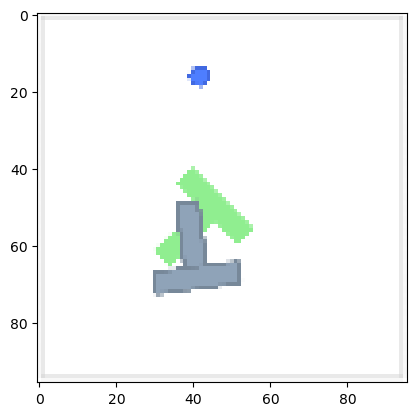

In [28]:
plt.imshow(russ_data['data']['img'][1].astype(np.int))
plt.show()